In [0]:
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [0]:
# constants

FOLDER_MNIST_PATH = 'MNIST'

DS_LOADER_BATCH_SIZE = 64
DS_LOADER_SHUFFLE = True
DS_LOADER_DROP_LAST = True

TRAIN_N_EPOCHS = 10
TRAIN_LR = 1e-4


In [0]:
transformations = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.5], [0.5])])

train_set = datasets.MNIST(root=FOLDER_MNIST_PATH, download=True, train=True, transform=transformations)
test_set = datasets.MNIST(root=FOLDER_MNIST_PATH, download=True, train=False, transform=transformations)


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model

In [0]:
class Flatten(torch.nn.Module):   
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
        
class Flatten2Conv(torch.nn.Module):
    def __init__(self):
        super(Flatten2Conv, self).__init__()
        
    def forward(self, x):
        return x.view(x.shape[0], *[128, 7, 7]) # TODO: This size should be automatically defined..

class AE(nn.Module):
    
    def __init__(self):
        super(AE, self).__init__()
        
        conv1_in = 1
        conv1_out = 32
        conv2_out = 64
        conv3_out = 64
        conv4_out = 128
        
        flatten = Flatten()
        flatten2conv = Flatten2Conv()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=conv1_in, out_channels=conv1_out, kernel_size=5),    # [?,1,28,28] --> [?,conv1_out, 24, 24]
            nn.Tanh(),
            nn.Conv2d(in_channels=conv1_out, out_channels=conv2_out, kernel_size=5),   # [?,conv1_out, 24, 24] --> [?,conv2_out, 20, 20]
            nn.Tanh(),
            nn.Conv2d(in_channels=conv2_out, out_channels=conv3_out, kernel_size=11),  # [?,conv2_out, 20, 20] --> [?,conv3_out, 10, 10]
            nn.Tanh(),
            nn.Conv2d(in_channels=conv3_out, out_channels=conv4_out, kernel_size=4),   # [?,conv3_out, 10, 10] --> [?,conv4_out, 7, 7]
            nn.Tanh(),
            flatten,                                                                   # [?, conv4_out, 7, 7] --> [?,conv4_out * 7 * 7]            
            nn.Linear(conv4_out * 7 * 7, 2)                                            # [?, 6272] --> [?, 2]
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, conv4_out * 7 * 7),                         # [?,2] --> [?, 6272]
            flatten2conv,
            # https://pravn.wordpress.com/tag/transpose-convolutions/
            nn.ConvTranspose2d(conv4_out, conv3_out, 4),             # [?,conv4_out, 7, 7] --> [?,conv3_out, 10, 10]
            nn.Tanh(),
            nn.ConvTranspose2d(conv3_out, conv2_out, 11),            # [?,conv3_out, 10, 10] --> [?,conv2_out, 20, 20]
            nn.Tanh(),
            nn.ConvTranspose2d(conv2_out, conv1_out, 5),             # [?,conv2_out, 20, 20] --> [?,conv1_out, 24, 24]
            nn.Tanh(),
            nn.ConvTranspose2d(conv1_out, 1, 5),                     # [?,conv1_out, 24, 24] --> [?,1,28,28]
            nn.Tanh()
        ) 
        
    def forward(self, x):
        encoder_output = self.encoder(x)
        return self.decoder(encoder_output)
        

## Utils

In [0]:
def get_validation_performance(dataset, model, loss):
        model = model.to(device)
        test_loader = DataLoader(dataset=dataset, 
                          batch_size=DS_LOADER_BATCH_SIZE, 
                          shuffle=DS_LOADER_SHUFFLE, 
                          drop_last=DS_LOADER_DROP_LAST)
        
        n_batches = int(len(dataset)/DS_LOADER_BATCH_SIZE)
        moving_loss_test = 0
        with torch.no_grad():
            model = model.eval()
            for batch_ix_val, batch_data_test in enumerate(test_loader,0):
                x, label = batch_data_test
                x = x.to(device)
                label = label.to(device)
                
                img_pred = model(x)

                loss_test = loss(img_pred, x)
                moving_loss_test += loss_test.item()


        avg_batch_loss_test = moving_loss_test/n_batches
        return avg_batch_loss_test 
      
def get_validation_performance_vae(dataset, model, loss, r_loss_factor):
        model = model.to(device)
        test_loader = DataLoader(dataset=dataset, 
                          batch_size=DS_LOADER_BATCH_SIZE, 
                          shuffle=DS_LOADER_SHUFFLE, 
                          drop_last=DS_LOADER_DROP_LAST)
        
        n_batches = int(len(dataset)/DS_LOADER_BATCH_SIZE)
        moving_loss_test = 0
        with torch.no_grad():
            model = model.eval()
            for batch_ix_val, batch_data_test in enumerate(test_loader,0):
                x, _ = batch_data_test
                x = x.to(device)
                
                img_pred, mu, log_var = model(x)

                loss_test = loss(img_pred, x, mu, log_var, r_loss_factor)
                moving_loss_test += loss_test.item()


        avg_batch_loss_test = moving_loss_test/n_batches
        return avg_batch_loss_test       
      
def show_images(images):
    normal_imgs = (images/2 + 0.5).numpy()
    plt.imshow(np.transpose(normal_imgs, [1,2,0])) # test.shape = torch.Size([3, 32, 32])          

## Training Loop

In [79]:
autoencoder = AE()
autoencoder = autoencoder.to(device)
rmse_loss = nn.MSELoss()
optimiser = optim.Adam(autoencoder.parameters(), lr=TRAIN_LR)

running_loss_train = 0

n_batches = int(len(train_set)/DS_LOADER_BATCH_SIZE)
for e in range(TRAIN_N_EPOCHS):
    train_loader = DataLoader(dataset=train_set, 
                              batch_size=DS_LOADER_BATCH_SIZE, 
                              shuffle=DS_LOADER_SHUFFLE, 
                              drop_last=DS_LOADER_DROP_LAST)
    running_loss_train = 0 
    for batch_ix, data in enumerate(train_loader, 0):
        x, label = data
        x = x.to(device)
        label = label.to(device)
        
        optimiser.zero_grad()
        img_predictions = autoencoder(x)
        
        loss = rmse_loss(img_predictions, x)
        running_loss_train += loss
        
        loss.backward()
        
        optimiser.step()
        
    avg_running_loss_train = running_loss_train/n_batches
    print(f'epoch {e}:')
    print(f'Training Loss: {avg_running_loss_train}')
    
    avg_running_loss_test = get_validation_performance(dataset=test_set,
                                                    model=autoencoder,
                                                    loss=rmse_loss)
    print(f'Validation Loss: {avg_running_loss_test}')
    print(f'--------------------------------')
    
    


epoch 0:
Training Loss: 0.22317393124103546
Validation Loss: 0.1935286129323336
--------------------------------
epoch 1:
Training Loss: 0.18907281756401062
Validation Loss: 0.18177384176315406
--------------------------------
epoch 2:
Training Loss: 0.1803375631570816
Validation Loss: 0.17663986694354278
--------------------------------
epoch 3:
Training Loss: 0.1747644543647766
Validation Loss: 0.1708872196957087
--------------------------------
epoch 4:
Training Loss: 0.17019698023796082
Validation Loss: 0.1678918572381521
--------------------------------
epoch 5:
Training Loss: 0.1669939160346985
Validation Loss: 0.16601648047948495
--------------------------------
epoch 6:
Training Loss: 0.16396594047546387
Validation Loss: 0.1619315288769893
--------------------------------
epoch 7:
Training Loss: 0.1610967218875885
Validation Loss: 0.15896871370764878
--------------------------------
epoch 8:
Training Loss: 0.158614382147789
Validation Loss: 0.1566090329717367
------------------

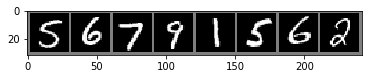

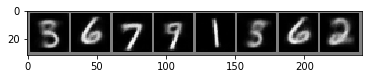

In [80]:
autoencoder.cpu()
test_loader = DataLoader(dataset=test_set, 
                          batch_size=8, 
                          shuffle=DS_LOADER_SHUFFLE, 
                          drop_last=DS_LOADER_DROP_LAST)
test_loader = iter(test_loader)
data, label = next(test_loader)
with torch.no_grad():
    pred = autoencoder(data)

N_IMAGES = 8  
show_images(torchvision.utils.make_grid(data[:N_IMAGES]))
plt.show()
show_images(torchvision.utils.make_grid(pred[:N_IMAGES]))

## Checkpoint

In [0]:
# torch.save(autoencoder, 'drive/My Drive/autoencoder_model.pt') # Google Colab

autoencoder = torch.load('drive/My Drive/autoencoder_model.pt')
autoencoder = autoencoder.eval()

In [81]:
test_loader = iter(DataLoader(dataset=test_set, 
                          batch_size=10000, 
                          shuffle=DS_LOADER_SHUFFLE, 
                          drop_last=DS_LOADER_DROP_LAST))

data, label = next(test_loader)
with torch.no_grad():
    space = autoencoder.encoder(data).numpy()

    
## Create dataset
latent_space = pd.DataFrame(space, columns=['x', 'y'])
latent_space['label'] = label.numpy()
latent_space = latent_space.sort_values('label')

# seaborn doesn't accept numerical labels: https://github.com/mwaskom/seaborn/issues/1515
nbr_str = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
map_nbr2str = {nbr: str_ for nbr, str_ in zip(list(range(10)), nbr_str)}
latent_space['label'] = [map_nbr2str[e] for e in latent_space['label']]

latent_space.head()

,x,y,label
0,8.273479,-10.945738,zero
8475,5.866023,-11.129955,zero
8478,15.482284,-15.245453,zero
5883,6.444799,-7.902953,zero
1319,5.336591,-7.539581,zero


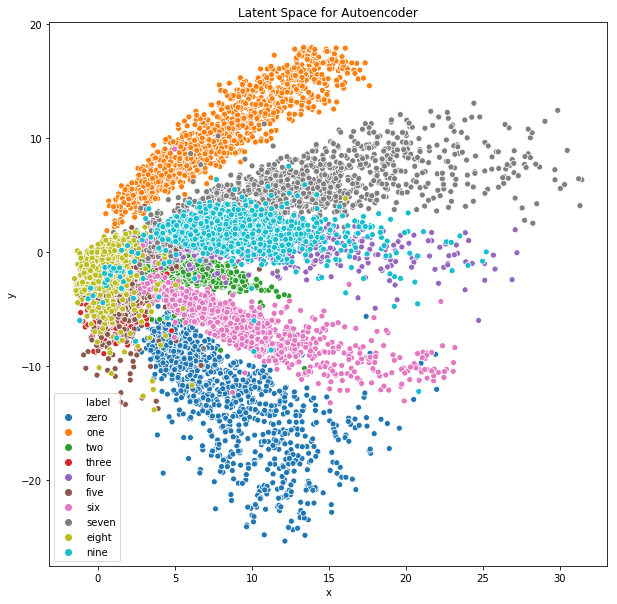

In [82]:
fig, ax = plt.subplots(figsize=[10,10])
sns.scatterplot(x='x', 
                y='y',
                hue = 'label',
                data=latent_space)
plt.title('Latent Space for Autoencoder');

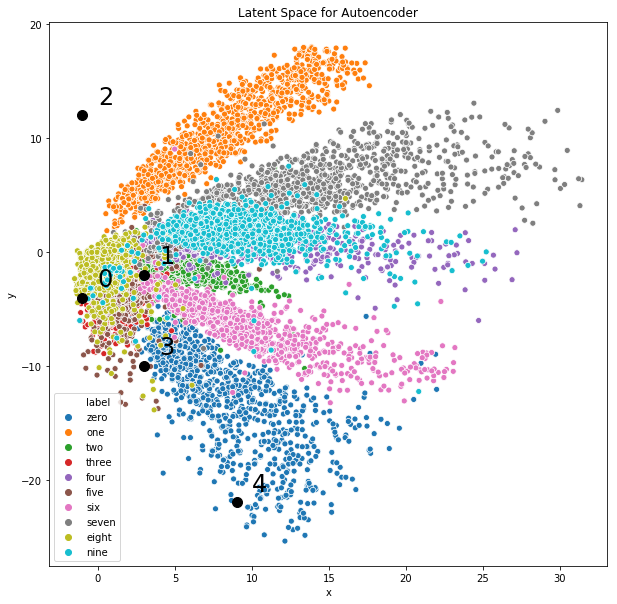

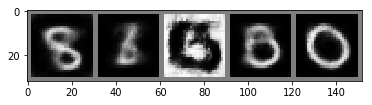

In [83]:
fig, ax = plt.subplots(figsize=[10,10])
sns.scatterplot(x='x', 
                y='y',
                hue = 'label',
                data=latent_space)

n = 5
points_x = np.random.randint(latent_space['x'].min(), latent_space['x'].max(),n)
points_y = np.random.randint(latent_space['y'].min(), latent_space['y'].max(),n)
points = [points_x, points_y]

point_order = list(range(len(points[0])))
plt.scatter(points[0],points[1], marker='o',color='black',s=100)
for i in range(len(points[0])):
    plt.text(points[0][i]+1,points[1][i]+1, point_order[i], fontsize=24)
plt.title('Latent Space for Autoencoder');
plt.show()


points2 = [[e1,e2] for e1,e2 in zip(points[0], points[1])]
points_encoder = torch.tensor(points2).view(len(points2),2).type(torch.float) # one batch, 4 images with 2 points
with torch.no_grad():
    images = autoencoder.decoder(points_encoder)

show_images(torchvision.utils.make_grid(images))    

# Variational Autoencoder

In [0]:
class Print(nn.Module):
    def __init__(self):
        super(Print, self).__init__()
    def forward(self,x):
        print(x.size())
        return x
    
class Flatten(torch.nn.Module):   
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
        
class Flatten2Conv(torch.nn.Module):
    def __init__(self):
        super(Flatten2Conv, self).__init__()
        
    def forward(self, x):
        return x.view(x.shape[0], *[128, 7, 7]) # TODO: This size should be automatically defined..

class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        
        conv1_in = 1
        conv1_out = 32
        conv2_out = 64
        conv3_out = 64
        conv4_out = 128
        
        flatten = Flatten()
        flatten2conv = Flatten2Conv()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=conv1_in, out_channels=conv1_out, kernel_size=5),    # [?,1,28,28] --> [?,conv1_out, 24, 24]
            nn.Tanh(),
            nn.Conv2d(in_channels=conv1_out, out_channels=conv2_out, kernel_size=5),   # [?,conv1_out, 24, 24] --> [?,conv2_out, 20, 20]
            nn.Tanh(),
            nn.Conv2d(in_channels=conv2_out, out_channels=conv3_out, kernel_size=11),  # [?,conv2_out, 20, 20] --> [?,conv3_out, 10, 10]
            nn.Tanh(),
            nn.Conv2d(in_channels=conv3_out, out_channels=conv4_out, kernel_size=4),   # [?,conv3_out, 10, 10] --> [?,conv4_out, 7, 7]
            nn.Tanh(),
            flatten,                                                                   # [?, conv4_out, 7, 7] --> [?,conv4_out * 7 * 7 (6272)]            
                                                       
        )
        
        self.encode_mu = nn.Linear(conv4_out * 7 * 7, 2)                               # [?, 6272] --> [?, 2]
        self.encode_log_var = nn.Linear(conv4_out * 7 * 7, 2)                          # [?, 6272] --> [?, 2]
        
        self.decoder = nn.Sequential(
            nn.Linear(2, conv4_out * 7 * 7),                         # [?,2] --> [?, 6272]
            flatten2conv,
            # https://pravn.wordpress.com/tag/transpose-convolutions/
            nn.ConvTranspose2d(conv4_out, conv3_out, 4),             # [?,conv4_out, 7, 7] --> [?,conv3_out, 10, 10]
            nn.Tanh(),
            nn.ConvTranspose2d(conv3_out, conv2_out, 11),            # [?,conv3_out, 10, 10] --> [?,conv2_out, 20, 20]
            nn.Tanh(),
            nn.ConvTranspose2d(conv2_out, conv1_out, 5),             # [?,conv2_out, 20, 20] --> [?,conv1_out, 24, 24]
            nn.Tanh(),
            nn.ConvTranspose2d(conv1_out, conv1_in, 5),              # [?,conv1_out, 24, 24] --> [?,1,28,28]
            nn.Tanh()
        )
        
    def resample(self, mu, log_var):
        sigma = torch.exp(log_var/2)
        variability = torch.randn(2, device=device)
        return mu + sigma * variability
        
    def forward(self, x):
        encoder_output = self.encoder(x)
        
        mu = self.encode_mu(encoder_output)
        log_var = self.encode_log_var(encoder_output)
        
        z = self.resample(mu, log_var)
        return self.decoder(z), mu, log_var
      
mse_loss = nn.MSELoss()      
    
def loss_function(recon_x, x, mu, log_var, r_loss_factor):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    log_var: latent log variance
    """
    r_loss = mse_loss(recon_x, x) 
    
    kl_loss = -0.5 * torch.sum(1 + log_var - torch.pow(mu,2) - torch.exp(log_var), dim=1)
    kl_loss = torch.sum(kl_loss)
    
    return r_loss_factor * r_loss + kl_loss    
    
    
        

In [39]:
# constants
TRAIN_N_EPOCHS = 200
R_LOSS_FACTOR = 10000

v_autoencoder = VAE()
v_autoencoder = v_autoencoder.to(device)

optimiser = optim.Adam(v_autoencoder.parameters(), lr=TRAIN_LR)

n_batches = int(len(train_set)/DS_LOADER_BATCH_SIZE)

mse_loss = nn.MSELoss()     

for e in range(TRAIN_N_EPOCHS):
    train_loader = DataLoader(dataset=train_set, 
                              batch_size=DS_LOADER_BATCH_SIZE, 
                              shuffle=DS_LOADER_SHUFFLE, 
                              drop_last=DS_LOADER_DROP_LAST)
    running_loss_train = 0
    for batch_ix, data in enumerate(train_loader, 0):
        x, _ = data
        x = x.to(device)
        
        optimiser.zero_grad()
        img_predictions, mu, log_var = v_autoencoder(x)
        
        loss = loss_function(img_predictions, x, mu, log_var, R_LOSS_FACTOR)
        running_loss_train += loss
        
        loss.backward()
        
        optimiser.step()
        
    avg_running_loss_train = running_loss_train/n_batches
    print(f'epoch {e}:')
    print(f'Training Loss: {avg_running_loss_train}')
    
    avg_running_loss_test = get_validation_performance_vae(dataset=test_set,
                                                    model=v_autoencoder,
                                                    loss=loss_function,
                                                    r_loss_factor=R_LOSS_FACTOR)
    print(f'Validation Loss: {avg_running_loss_test}')
    print(f'--------------------------------')
    
    


epoch 0:
Training Loss: 2536.996826171875
Validation Loss: 2292.4100521772334
--------------------------------
epoch 1:
Training Loss: 2239.934814453125
Validation Loss: 2295.5488969851763
--------------------------------
epoch 2:
Training Loss: 2192.426025390625
Validation Loss: 2154.5911896534453
--------------------------------
epoch 3:
Training Loss: 2151.513916015625
Validation Loss: 2150.43853133764
--------------------------------
epoch 4:
Training Loss: 2122.28173828125
Validation Loss: 2140.295345991086
--------------------------------
epoch 5:
Training Loss: 2115.77978515625
Validation Loss: 2170.5300410344053
--------------------------------
epoch 6:
Training Loss: 2100.1708984375
Validation Loss: 2084.743134327424
--------------------------------
epoch 7:
Training Loss: 2075.796142578125
Validation Loss: 2050.185270651793
--------------------------------
epoch 8:
Training Loss: 2075.21337890625
Validation Loss: 2043.863001896785
--------------------------------
epoch 9:
Tra

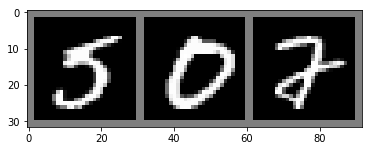

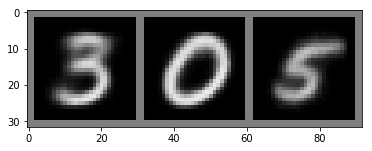

In [45]:
v_autoencoder.to(device)
test_loader = DataLoader(dataset=test_set, 
                          batch_size=8, 
                          shuffle=DS_LOADER_SHUFFLE, 
                          drop_last=DS_LOADER_DROP_LAST)
test_loader = iter(test_loader)
data, _ = next(test_loader)
with torch.no_grad():
    data = data.to(device)
    pred, mu, log_var = v_autoencoder(data)
    
def show_images(images):
    normal_imgs = (images/2 + 0.5).numpy()
    plt.imshow(np.transpose(normal_imgs, [1,2,0])) # test.shape = torch.Size([3, 32, 32])    

N_IMAGES = 3 
data = data.cpu()
show_images(torchvision.utils.make_grid(data[:N_IMAGES]))
plt.show()
pred = pred.cpu()
show_images(torchvision.utils.make_grid(pred[:N_IMAGES]))

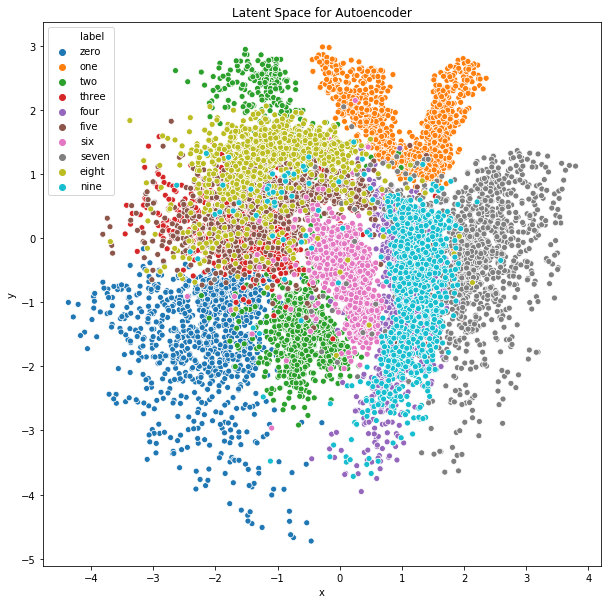

In [41]:
test_loader = iter(DataLoader(dataset=test_set, 
                          batch_size=10000, 
                          shuffle=DS_LOADER_SHUFFLE, 
                          drop_last=DS_LOADER_DROP_LAST))

data, label = next(test_loader)
data = data.to(device)

with torch.no_grad():
    space = v_autoencoder.encoder(data)
    
    mu = v_autoencoder.encode_mu(space)
    log_var = v_autoencoder.encode_log_var(space)

    z = v_autoencoder.resample(mu, log_var)


    
## Create dataset
latent_space = pd.DataFrame(z, columns=['x', 'y'])
latent_space['label'] = label.numpy()
latent_space = latent_space.sort_values('label')

# seaborn doesn't accept numerical labels: https://github.com/mwaskom/seaborn/issues/1515
nbr_str = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
map_nbr2str = {nbr: str_ for nbr, str_ in zip(list(range(10)), nbr_str)}
latent_space['label'] = [map_nbr2str[e] for e in latent_space['label']]


fig, ax = plt.subplots(figsize=[10,10])
sns.scatterplot(x='x', 
                y='y',
                hue = 'label',
                data=latent_space)
plt.title('Latent Space for Autoencoder');

In [0]:
# torch.save(v_autoencoder, 'drive/My Drive/variational_autoencoder_model.pt') # Google Colab